## Exploring Themes in AI Regulation: A Comparative NLP Study

### Setup and Imports

Loading the libraries needed for tokenization, stopword removal, and topic modeling.


In [1]:
from utils.extract_pdf_contents import process_pdfs
from utils.clean_texts import clean_EU_legal_text, clean_US_legal_text
from utils.TFIDF_model import load_text, compute_tfidf, save_tfidf_values
from sklearn.feature_extraction.text import CountVectorizer
import spacy
import nltk
import spacy


import warnings
warnings.filterwarnings("ignore", category=UserWarning)

### 1. Text Extraction

In [2]:
# Define the input and output directories
input_directory = "data/raw" 
output_directory = "data/extracted_text" 


# Call the function to process the PDFs
process_pdfs(input_directory, output_directory)

Extracted text saved to: data/extracted_text/EU_AI_Act_English.txt
Extracted text saved to: data/extracted_text/USA_AI_Executive_Order_English.txt


### 2. Data Wrangling and Loading

In [3]:
# First the EU Act

# Read the file content and pass it to clean_legal_text
with open("data/extracted_text/EU_AI_Act_English.txt", "r", encoding="utf-8") as file:
    text = file.read()

clean_EU_text = clean_EU_legal_text(text)

# Save cleaned text to /data/cleaned_text directory
with open("data/cleaned_text/EU_AI_Act_English_Cleaned.txt", "w", encoding="utf-8") as file:
    file.write(clean_EU_text)


# Second, the USA AI Executive Order

# Read the file content and pass it to clean_legal_text
with open("data/extracted_text/USA_AI_Executive_Order_English.txt", "r", encoding="utf-8") as file:
    text = file.read()
    clean_US_text = clean_US_legal_text(text)

# Save cleaned text to /data/cleaned_text directory
with open("data/cleaned_text/USA_AI_Executive_Order_English_Cleaned.txt", "w", encoding="utf-8") as file:
    file.write(clean_US_text)

### 3. Tokenization

In [4]:
# Paths to the cleaned text files
text_file_1 = "data/cleaned_text/EU_AI_Act_English_Cleaned.txt"
text_file_2 = "data/cleaned_text/USA_AI_Executive_Order_English_Cleaned.txt"

# Load the cleaned texts
text1 = load_text(text_file_1)
text2 = load_text(text_file_2)

if not spacy.util.is_package("en_core_web_sm"):
    silent_spacy_download("en_core_web_sm")
nlp = spacy.load("en_core_web_sm", disable=["tok2vec", "tagger", "parser", "ner",
                                                "lemmatizer", "attibute_ruler"]) 
nltk.download("stopwords", quiet=True)
stop_words_en = nltk.corpus.stopwords.words("english")

# Custom tokenization function
def custom_tokenizer(text):
    tokenized_text = nlp(text)
    return [tok.text.strip() for tok in tokenized_text if tok.text.strip() != '' and not tok.is_punct]

# Manual tokenization using the custom tokenizer (for inspection purposes)
tokens_EU_AI = custom_tokenizer(text1)
tokens_US_AI = custom_tokenizer(text2)

# Saving the tokens to files for inspection
with open("data/tokens/EU_AI_Act_Tokens.txt", "w", encoding="utf-8") as f:
    for token in tokens_EU_AI:
        f.write(f"{token}\n")

with open("data/tokens/USA_AI_Executive_Order_Tokens.txt", "w", encoding="utf-8") as f:
    for token in tokens_US_AI:
        f.write(f"{token}\n")


# Load NLTK stopwords
stop_words_en = nltk.corpus.stopwords.words("english")

# Add missing tokenized forms
additional_stopwords = ["'d", "'ll", "'m", "'re", "'s", "'ve", 
                        "could", "might", "must", "n't", "need", 
                        "sha", "wo", "would"]
stop_words_en = list(set(stop_words_en + additional_stopwords))



#### 3.1. Word Frequency Analysis

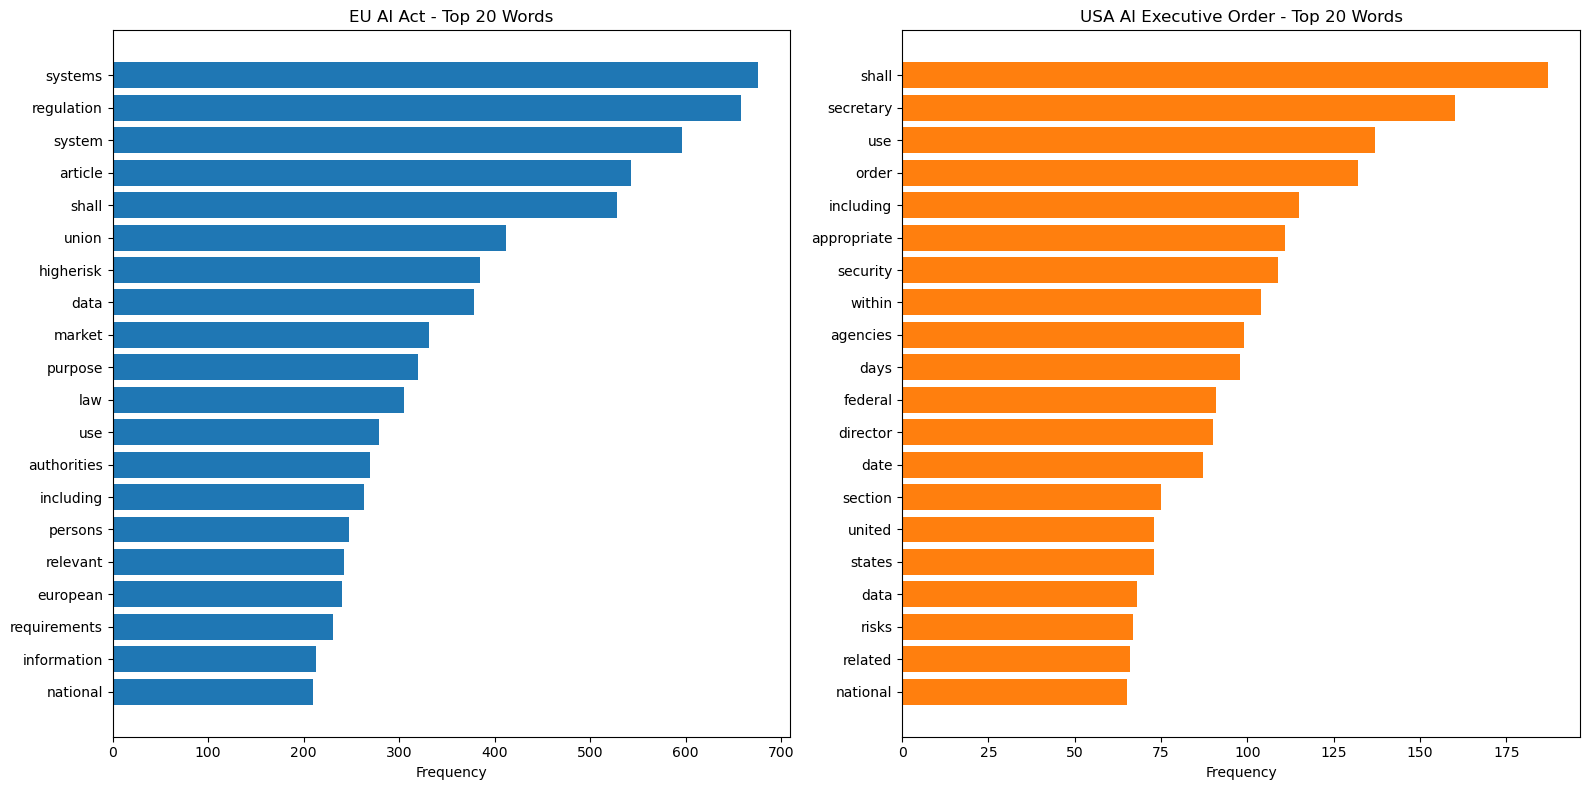

EU AI Act - Total unique words: 3702
USA AI Executive Order - Total unique words: 2834

Common words in both documents: 1356


In [5]:
from collections import Counter
import matplotlib.pyplot as plt

# Filter out stopwords from tokens
tokens_EU_filtered = [token.lower() for token in tokens_EU_AI 
                      if token.lower() not in stop_words_en and len(token) > 2]
tokens_US_filtered = [token.lower() for token in tokens_US_AI 
                      if token.lower() not in stop_words_en and len(token) > 2]

# Count word frequencies
eu_freq = Counter(tokens_EU_filtered)
us_freq = Counter(tokens_US_filtered)

# Get top N most common words
top_n = 20
eu_top = eu_freq.most_common(top_n)
us_top = us_freq.most_common(top_n)

# Create side-by-side bar charts
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# EU AI Act
eu_words, eu_counts = zip(*eu_top)
axes[0].barh(range(len(eu_words)), eu_counts, color='#1f77b4')
axes[0].set_yticks(range(len(eu_words)))
axes[0].set_yticklabels(eu_words)
axes[0].invert_yaxis()
axes[0].set_xlabel('Frequency')
axes[0].set_title('EU AI Act - Top 20 Words')

# USA AI Executive Order
us_words, us_counts = zip(*us_top)
axes[1].barh(range(len(us_words)), us_counts, color='#ff7f0e')
axes[1].set_yticks(range(len(us_words)))
axes[1].set_yticklabels(us_words)
axes[1].invert_yaxis()
axes[1].set_xlabel('Frequency')
axes[1].set_title('USA AI Executive Order - Top 20 Words')

plt.tight_layout()
plt.savefig('plots/word_frequency_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

# Print frequency statistics
print(f"EU AI Act - Total unique words: {len(eu_freq)}")
print(f"USA AI Executive Order - Total unique words: {len(us_freq)}")
print(f"\nCommon words in both documents: {len(set(eu_freq.keys()) & set(us_freq.keys()))}")


### 4. Feature extraction

#### 4.1. Bag of Words (BoW)

In [6]:
# Vectorizer Configuration for BoW (required for LDA)
tokenizer_bow = CountVectorizer(analyzer="word",
                                tokenizer=custom_tokenizer,
                                lowercase=True,
                                stop_words=stop_words_en)
text1_bow = tokenizer_bow.fit_transform([text1])
print(f"BoW Matrix Dimensions EU AI Act: {text1_bow.shape}")

text2_bow = tokenizer_bow.fit_transform([text2])
print(f"BoW Matrix Dimensions USA AI Executive Order: {text2_bow.shape}")

BoW Matrix Dimensions EU AI Act: (1, 3842)
BoW Matrix Dimensions USA AI Executive Order: (1, 2912)


#### 4.2. TF-IDF

In [7]:
if text1 and text2:
    # Compute TF-IDF
    feature_names, tfidf_matrix = compute_tfidf([text1, text2])
    
    # Save TF-IDF tokens
    output_directory = "data/tfidf_values"
    save_tfidf_values(output_directory, feature_names, tfidf_matrix)

TF-IDF values saved to: data/tfidf_values/tfidf_doc_1.txt
TF-IDF values saved to: data/tfidf_values/tfidf_doc_2.txt


#### 4.3. Embeddings (Word2Vec)

In [8]:
# Import the Word2VecModel class
from utils.word2vec_module import Word2VecModel
import gensim.downloader as api

# Load pretrained Word2Vec embeddings (Google News 300d)
print("Loading pretrained Word2Vec model (this may take a few minutes)...")
pretrained_model = api.load("word2vec-google-news-300")

# Wrap in Word2VecModel class for compatibility
word2vec = Word2VecModel(vector_size=300, window=5, min_count=2, workers=4)
word2vec.model = pretrained_model

# Save the pretrained model for future use
word2vec.save("data/embeddings/word2vec_pretrained")

# Example: Get embedding for a specific word
if "AI" in pretrained_model:
    get_vector = word2vec.get_vector("AI")
    print(f"Vector for 'AI': {get_vector[:10]}...")  # Show first 10 dimensions
else:
    print("'AI' not found in pretrained vocabulary")


Loading pretrained Word2Vec model (this may take a few minutes)...
Vector for 'AI': [ 0.18066406  0.01342773  0.14746094  0.00302124 -0.16699219  0.00540161
 -0.25976562  0.01556396 -0.18457031 -0.11035156]...


### 5. Mathematical analysis

#### 5.1. Similarity Measurement (Cosine Similiarity)

In [9]:
import numpy as np

# WORK IN PROGRESS

# Example: Find similar words
try:
    similar_words = word2vec.most_similar("AI", topn=5)
    print(f"Words similar to 'AI': {similar_words}")
except KeyError:
    print("'AI' not found in pretrained vocabulary")

# Example: Compute similarity between two words
try:
    similarity = word2vec.similarity("AI", "artificial")
    print(f"Similarity between 'AI' and 'artificial': {similarity}")
except KeyError as e:
    print(f"Word not found in vocabulary: {e}")

# Example: Compute similarity between two documents
doc1_vector = word2vec.document_vector(tokens_EU_AI)
doc2_vector = word2vec.document_vector(tokens_US_AI)
doc_similarity = word2vec.cosine_similarity(doc1_vector, doc2_vector)
print(f"Similarity between EU AI Act and USA AI Executive Order: {doc_similarity}")

# Example: Find most similar words to a document
most_similar_to_doc = word2vec.most_similar_to_document(tokens_EU_AI, topn=5)
print(f"Words most similar to EU AI Act: {most_similar_to_doc}")

### TESTING 
# Arithmetic operations with word embeddings
# Example: "regulation" - "law" + "policy" = ?
try:
    result = word2vec.model.most_similar(
        positive=["regulation", "policy"],
        negative=["law"],
        topn=5
    )
    print(f"\n'regulation' - 'law' + 'policy' = {result}")
except KeyError as e:
    print(f"Word not found in vocabulary: {e}")

# Analogy: "risk" is to "assessment" as "data" is to ?
try:
    analogy_result = word2vec.model.most_similar(
        positive=["data", "assessment"],
        negative=["risk"],
        topn=3
    )
    print(f"\nAnalogy - 'risk':'assessment' :: 'data':? = {analogy_result}")
except KeyError as e:
    print(f"Word not found in vocabulary: {e}")

# Find outlier word in a list
try:
    outlier = word2vec.model.doesnt_match(["AI", "algorithm", "technology", "banana"])
    print(f"\nOutlier in ['AI', 'algorithm', 'technology', 'banana']: {outlier}")
except KeyError as e:
    print(f"Word not found in vocabulary: {e}")

# Compute centroid of multiple words (semantic center)
concept_words = ["AI", "data", "model", "system"]
valid_vectors = [word2vec.get_vector(word) for word in concept_words 
                 if word in word2vec.model]
if valid_vectors:
    centroid = np.mean(valid_vectors, axis=0)
    similar_to_centroid = word2vec.model.similar_by_vector(centroid, topn=5)
    print(f"\nWords closest to centroid of {concept_words}: {similar_to_centroid}")

# Measure semantic distance between two documents (Euclidean distance)
euclidean_dist = np.linalg.norm(doc1_vector - doc2_vector)
print(f"\nEuclidean distance between documents: {euclidean_dist:.4f}")

# Find words unique to each document (low cosine similarity)
eu_unique = []
us_unique = []
for word in tokens_EU_filtered[:100]:  # Sample first 100 filtered tokens
    if word in word2vec.model:
        try:
            # Check similarity with US document tokens
            us_sample = [w for w in tokens_US_filtered[:100] if w in word2vec.model]
            if us_sample:
                sim = word2vec.model.n_similarity([word], us_sample)
                if sim < 0.3:  # Low similarity threshold
                    eu_unique.append((word, sim))
        except KeyError:
            continue

print(f"\nWords more unique to EU document (sample): {eu_unique[:5]}")

Words similar to 'AI': [('Steven_Spielberg_Artificial_Intelligence', 0.5575933456420898), ('Index_MDE_##/###/####', 0.5415324568748474), ('Enemy_AI', 0.5256391763687134), ('Ace_Combat_Zero', 0.522663414478302), ('DOA4', 0.5182536840438843)]
Similarity between 'AI' and 'artificial': 0.12092454731464386
Similarity between EU AI Act and USA AI Executive Order: 0.9623271822929382
Words most similar to EU AI Act: [('By_Laurelle_Gilbert', 0.710679292678833), ('By_Jonas_Elmerraji', 0.6993436813354492), ('%_#F########_9v.jsn', 0.6937677264213562), ('By_Kat_Zeman', 0.6933881640434265), ('By_Joseph_Woelfel', 0.6910573840141296)]

'regulation' - 'law' + 'policy' = [('policies', 0.47434794902801514), ('polices', 0.42326420545578003), ('regulatory_framework', 0.41972559690475464), ('macro_prudential_regulation', 0.41675639152526855), ('ultra_accommodative_monetary', 0.4133623540401459)]

Analogy - 'risk':'assessment' :: 'data':? = [('assessments', 0.5592548251152039), ('assesment', 0.50556629896163

#### 5.2. Dimensionality Reduction (t-SNE)

In [ ]:
# t-SNE Visualization
from utils.tsne_visualization import plot_tsne_embeddings
import numpy as np

# Get unique words from both documents that exist in the Word2Vec model
document_words = set(tokens_EU_filtered + tokens_US_filtered)
max_words = 250

# Filter to words that exist in the pretrained model
filtered_words = []
filtered_embeddings = []

for word in document_words:
    if word in word2vec.model:
        filtered_words.append(word)
        filtered_embeddings.append(word2vec.get_vector(word))
    
    if len(filtered_words) >= max_words:
        break

embeddings = np.array(filtered_embeddings)
words = filtered_words

print(f"Visualizing {len(words)} words from the documents")
print(f"Total unique words in both documents: {len(document_words)}")

# Plot t-SNE embeddings and save
plot_tsne_embeddings(embeddings, words, "plots/tsne_embeddings.png")


Visualizing 250 words from the documents
Total unique words in both documents: 5180
Words found in Word2Vec model: 250


### 6. Topic Modeling

#### 6.1. Latent Dirichlet Allocation (LDA)

In [ ]:
from sklearn.decomposition import LatentDirichletAllocation

# Combine both documents for topic modeling
combined_bow = tokenizer_bow.fit_transform([text1, text2])
feature_names = tokenizer_bow.get_feature_names_out()

# Initialize and fit LDA model
n_topics = 5  # Number of topics to extract
lda_model = LatentDirichletAllocation(n_components=n_topics,
                                       max_iter=10,
                                       learning_method='online',
                                       random_state=42)
lda_model.fit(combined_bow)

# Display top words for each topic
def display_topics(model, feature_names, n_top_words=10):
    for topic_idx, topic in enumerate(model.components_):
        top_words = [feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]]
        print(f"Topic {topic_idx + 1}: {', '.join(top_words)}")

print("LDA Topics:")
display_topics(lda_model, feature_names)

# Get topic distribution for each document
doc_topics = lda_model.transform(combined_bow)
print(f"\nTopic distribution for EU AI Act: {doc_topics[0]}")
print(f"Topic distribution for USA AI Executive Order: {doc_topics[1]}")

#### 6.2. LDA with TF-IDF

In [ ]:
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import TfidfVectorizer

# Create TF-IDF vectorizer with custom tokenizer
tfidf_vectorizer = TfidfVectorizer(tokenizer=custom_tokenizer,
                                    lowercase=True,
                                    stop_words=stop_words_en)

# Fit and transform the texts
tfidf_for_lda = tfidf_vectorizer.fit_transform([text1, text2])
tfidf_feature_names = tfidf_vectorizer.get_feature_names_out()

# Initialize and fit LDA model with TF-IDF
n_topics_tfidf = 5
lda_tfidf_model = LatentDirichletAllocation(n_components=n_topics_tfidf,
                                             max_iter=10,
                                             learning_method='online',
                                             random_state=42)
lda_tfidf_model.fit(tfidf_for_lda)

# Display top words for each topic
print("LDA Topics (using TF-IDF):")
display_topics(lda_tfidf_model, tfidf_feature_names)

# Get topic distribution for each document
doc_topics_tfidf = lda_tfidf_model.transform(tfidf_for_lda)
print(f"\nTopic distribution for EU AI Act (TF-IDF): {doc_topics_tfidf[0]}")
print(f"Topic distribution for USA AI Executive Order (TF-IDF): {doc_topics_tfidf[1]}")